In [2]:
import os
import re
from lib_log_parse import load_parsed_logs, parse
from typing import Dict, List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from typing import Tuple

sns.set_theme()

In [3]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [4]:
path = "../data/2022-12-07_hydra_dial_down"

In [6]:
values = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    if os.path.exists(file_path + ".p"):
        print(f"Skipping: {file_path}")
        continue

    values += [[file_path]]

with mp.Pool() as pool:
    pool.map(parse, values)

Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-1-node-5.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-1-node-4.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-1-node-6.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-1-node-3.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-1-node-2.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-1-node-0.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-1-node-1.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-2-node-2.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-2-node-3.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-2-node-1.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-2-node-0.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-2-node-4.log
Skipping: ../data/2022-12-07_hydra_dial_down/nodes-list-fleet-2-node-5.log
Skipping: ../data/2022-12

In [7]:
files = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    files += [file_path]

pool = mp.Pool(mp.cpu_count())
results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))


In [8]:
def log_origin(origin: str) -> Optional[Tuple[int, int]]:
    match = re.search(r".*\/nodes-list-fleet-(\d)-node-(\d).log", origin)
    if match is None:
        match = re.search(r".*\/nodes-list-ignore-hydras-node-(\d).log", origin)
        if match is None:
            return None
        return 3, int(match.group(1))

    fleet = int(match.group(1))
    node = int(match.group(2))
    return fleet, node


def map_region(fleet: int, node: int) -> str:
    if fleet == 1:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
    elif fleet == 2:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_us_ash"
    elif fleet == 3:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
        elif node == 7:
            return "hetzner_us_ash"
    raise Exception(f"unknown fleet {fleet} node {node} combination")


def region_from_origin(origin: str) -> str:
    fleet, node = log_origin(origin)
    return map_region(fleet, node)


results_by_region = {}

for idx, f in enumerate(files):
    region = region_from_origin(f)

    if not region in results_by_region:
        results_by_region[region] = []
    results_by_region[region] += [results[idx][0]]

In [9]:
df_retrievals_dict = {
    "fleet": [],
    "node": [],
    "region": [],
    "with_hydras": [],
    "started_at": [],
    "overall_retrieval_duration": [],
    "dht_walks_duration": [],
    "find_first_provider_duration": [],
    "content_fetch_duration": [],
    "find_provider_queries_count": [],
    "has_error": [],
}

In [10]:
publications: List[Publication] = []
retrievals: List[Retrieval] = []
for parsed_log in results:
    for log in parsed_log:
        publications += log.publications
        retrievals += log.retrievals

# Remove all retrievals that are marked as invalid
retrievals = list(
    filter(lambda ret: not ret.marked_as_incomplete, retrievals))
retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

for ret in retrievals:
    if ret.stream_opened_at is None or ret.connected_at is None:
        print("skip", ret.stream_opened_at, ret.connected_at)
        continue

    fleet, node = log_origin(ret.origin)
    region = map_region(fleet, node)
    # region = region_from_origin(ret.origin)
    if region is None:
        raise Exception("AHH")

    df_retrievals_dict["started_at"] += [ret.dial_started_at]
    df_retrievals_dict["with_hydras"] += [fleet != 3]
    df_retrievals_dict["fleet"] += [fleet]
    df_retrievals_dict["node"] += [node]
    df_retrievals_dict["region"] += [region]
    df_retrievals_dict["has_error"] += [ret.done_retrieving_error is not None]

    overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
    # simulate peer record retrieval by adding the DHT walk duration
    overall_retrieval_duration += ret.get_dht_walk_duration()
    df_retrievals_dict["overall_retrieval_duration"] += [overall_retrieval_duration]

    # simulate peer record retrieval by adding the DHT walk duration
    dht_walks_duration = 2 * ret.get_dht_walk_duration()
    df_retrievals_dict["dht_walks_duration"] += [dht_walks_duration]

    df_retrievals_dict["find_first_provider_duration"] += [(
                                                                   ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()]
    df_retrievals_dict["content_fetch_duration"] += [(ret.done_retrieving_at - ret.dial_started_at).total_seconds()]
    df_retrievals_dict["find_provider_queries_count"] += [
        len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))]

df_retrievals = pd.DataFrame.from_dict(df_retrievals_dict)

skip None 2022-11-26 01:27:56.673828+00:00
skip None 2022-11-26 03:13:57.461092+00:00
skip None 2022-11-27 09:26:22.142936+00:00
skip None 2022-11-28 03:40:53.378387+00:00
skip None 2022-11-28 03:51:49.151898+00:00
skip None 2022-11-28 21:49:54.634930+00:00
skip None 2022-11-29 09:15:23.821383+00:00
skip None 2022-11-30 04:57:03.082503+00:00
skip None 2022-12-01 07:42:08.747063+00:00
skip None 2022-12-03 14:31:35.642540+00:00
skip None 2022-12-01 21:24:29.975931+00:00
skip None 2022-12-05 01:38:56.754089+00:00
skip None 2022-11-26 13:08:16.063403+00:00
skip None 2022-11-26 16:13:45.958209+00:00
skip None 2022-11-26 19:48:54.547618+00:00
skip None 2022-11-26 20:33:48.770438+00:00
skip None 2022-11-27 08:41:53.912341+00:00
skip None 2022-11-29 06:56:58.477133+00:00
skip None 2022-12-02 20:57:36.165682+00:00
skip None 2022-11-26 20:33:48.931369+00:00
skip None 2022-11-27 08:41:54.222476+00:00
skip None 2022-11-27 12:01:38.543387+00:00
skip None 2022-11-30 04:57:03.006596+00:00
skip None 2

In [13]:
df_retrievals

,fleet,node,region,with_hydras,started_at,overall_retrieval_duration,dht_walks_duration,find_first_provider_duration,content_fetch_duration,find_provider_queries_count,has_error
0,1,5,sa_east_1,True,2022-11-25 15:27:38.000170+00:00,2.763128,0.935652,0.467620,0.826912,9,False
1,1,5,sa_east_1,True,2022-11-25 15:28:19.437798+00:00,3.105214,1.166052,0.582818,0.939379,10,False
2,1,5,sa_east_1,True,2022-11-25 15:30:01.470795+00:00,3.520702,1.370472,0.684979,1.149496,9,False
3,1,5,sa_east_1,True,2022-11-25 15:36:19.559704+00:00,1.935426,0.298094,0.148880,0.636968,10,False
4,1,5,sa_east_1,True,2022-11-25 15:41:15.275895+00:00,3.260032,1.436962,0.718299,0.822700,7,False
...,...,...,...,...,...,...,...,...,...,...,...
149810,3,0,me_south_1,False,2022-12-05 07:38:15.355192+00:00,2.225368,0.796642,0.398207,0.428010,5,False
149811,3,0,me_south_1,False,2022-12-05 07:39:01.693563+00:00,3.344597,1.690052,0.844874,0.654142,6,False
149812,3,0,me_south_1,False,2022-12-05 07:40:32.062085+00:00,2.954084,1.135266,0.567455,0.818133,12,False
149813,3,0,me_south_1,False,2022-12-05 07:41:10.773256+00:00,2.905072,1.636100,0.817897,0.268475,5,False


/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_41287/1038234031.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


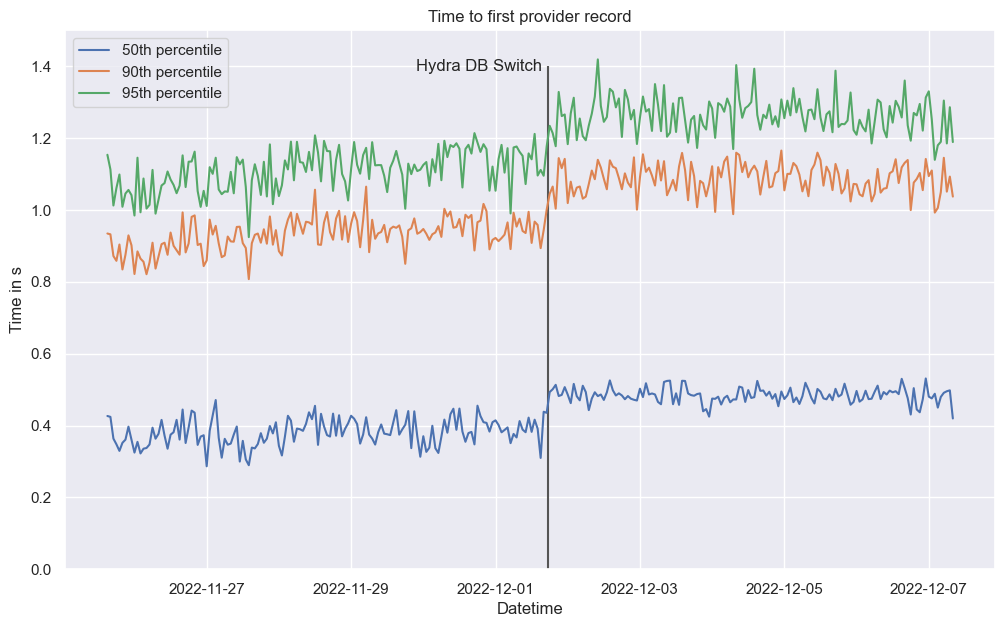

In [15]:
data = df_retrievals[df_retrievals["with_hydras"]]
data = data[data["started_at"] < "2022-12-07T09:00"]
grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
grp.find_first_provider_duration.quantile([.5, .9, .95])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=[12, 7])

event_time = datetime(year=2022, month=12, day=1, hour=17, minute=30)
ax.vlines(event_time, 0, 1.4, color="#555")
ax.text(datetime(year=2022, month=12, day=1, hour=15, minute=30), 1.4,"Hydra DB Switch", ha="right", va="center")

percentiles = [50, 90, 95]
for percentile in percentiles:
    dat = df[df["level_1"] == percentile / 100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile")

ax.set_ylabel("Time in s")
ax.set_xlabel("Datetime")
ax.set_title("Time to first provider record")
ax.set_ylim(0, 1.5)
ax.legend()

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_96722/1424404352.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


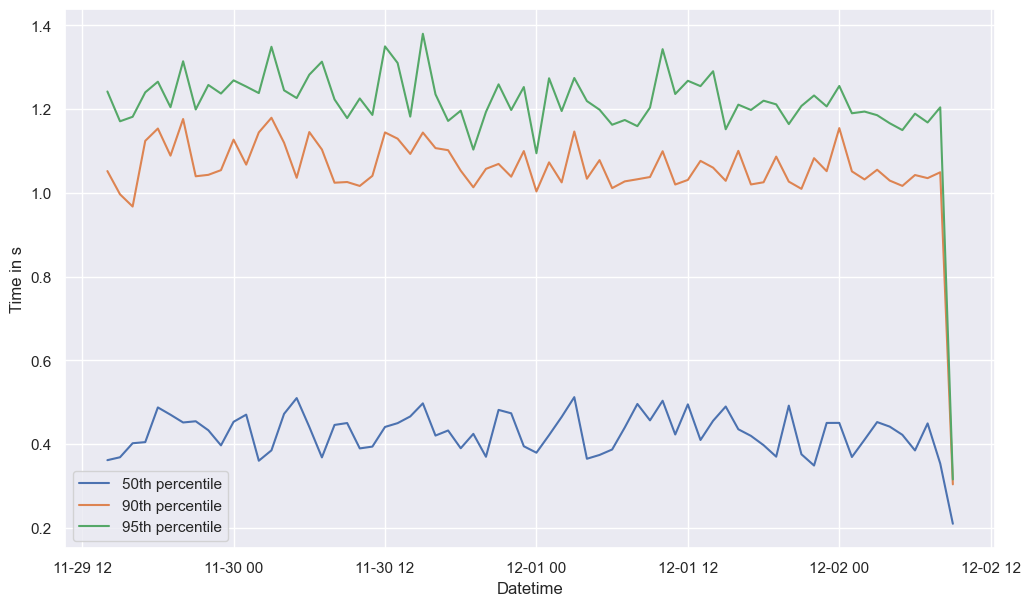

In [10]:
data = df_retrievals[df_retrievals["with_hydras"] == False]
data = data[data["started_at"] > "2022-11-29"]
grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
grp.find_first_provider_duration.quantile([.5, .9, .95])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=[12, 7])

percentiles = [50, 90, 95]
for percentile in percentiles:
    dat = df[df["level_1"] == percentile / 100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile")

ax.set_ylabel("Time in s")
ax.set_xlabel("Datetime")
ax.legend()

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_41287/2120762018.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])
/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_41287/2120762018.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


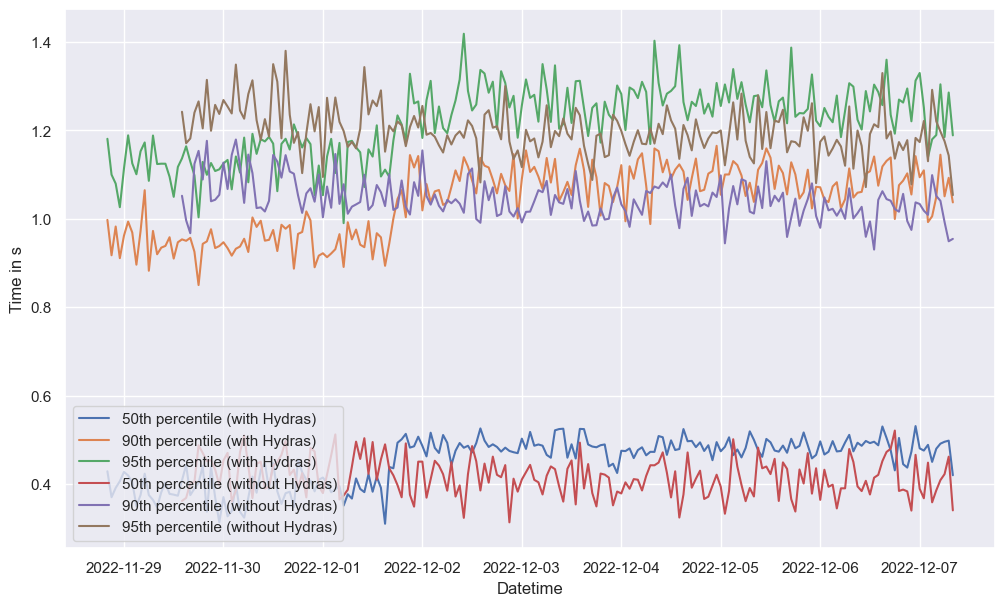

In [17]:
fig, ax = plt.subplots(figsize=[12, 7])

percentiles = [50, 90, 95]

data = df_retrievals[df_retrievals["with_hydras"] == True]
data = data[data["started_at"] < "2022-12-07T09:00"]
data = data[data["started_at"] > "2022-11-28T20:00"]
grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)

for percentile in percentiles:
    dat = df[df["level_1"] == percentile / 100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile (with Hydras)")

data = df_retrievals[df_retrievals["with_hydras"] == False]
data = data[data["started_at"] < "2022-12-07T09:00"]
grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)
df = df[df["started_at"] > '2022-11-28T20:00']

for percentile in percentiles:
    dat = df[df["level_1"] == percentile / 100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile (without Hydras)")

ax.set_ylabel("Time in s")
ax.set_xlabel("Datetime")
ax.legend(loc="lower left")

In [18]:

after_dial_down = df_retrievals[df_retrievals["with_hydras"] == True]
after_dial_down = after_dial_down[after_dial_down["started_at"] > "2022-12-01T17:30"]
after_dial_down

,fleet,node,region,with_hydras,started_at,overall_retrieval_duration,dht_walks_duration,find_first_provider_duration,content_fetch_duration,find_provider_queries_count,has_error
5151,1,5,sa_east_1,True,2022-12-01 17:30:31.212861+00:00,1.869204,0.326096,0.162914,0.542363,15,False
5152,1,5,sa_east_1,True,2022-12-01 17:31:15.046393+00:00,2.955144,1.331584,0.665598,0.623281,13,False
5153,1,5,sa_east_1,True,2022-12-01 17:32:59.630392+00:00,1.968526,0.324958,0.162148,0.643349,8,False
5154,1,5,sa_east_1,True,2022-12-01 17:35:02.206299+00:00,2.958444,1.015884,0.506483,0.941780,0,False
5155,1,5,sa_east_1,True,2022-12-01 17:36:43.164637+00:00,3.162897,1.622856,0.811235,0.539206,5,False
...,...,...,...,...,...,...,...,...,...,...,...
137831,2,6,hetzner_us_ash,True,2022-12-07 08:59:48.101691+00:00,2.119389,0.847322,0.423437,0.271345,6,False
137832,2,6,hetzner_us_ash,True,2022-12-07 09:02:23.846819+00:00,1.821076,0.122568,0.061100,0.698304,17,False
137833,2,6,hetzner_us_ash,True,2022-12-07 09:02:58.484795+00:00,1.893043,0.226966,0.113091,0.665542,14,False
137834,2,6,hetzner_us_ash,True,2022-12-07 09:05:12.553289+00:00,1.698230,0.304316,0.151936,0.393026,13,False


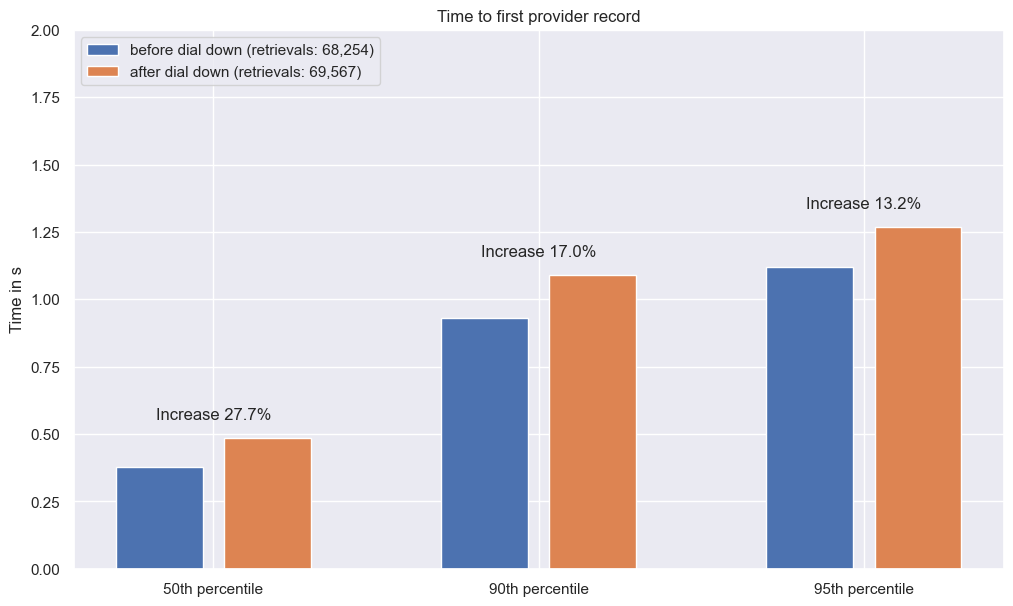

In [20]:

percentiles = [50, 90, 95]

fig, ax = plt.subplots(figsize=[12, 7])
before_dial_down = df_retrievals[df_retrievals["with_hydras"] == True]
before_dial_down = before_dial_down[before_dial_down["started_at"] < "2022-12-01T17:30"]

lats_before = []
for j, percentile in enumerate(percentiles):
    lats_before += [np.percentile(before_dial_down["find_first_provider_duration"], percentile)]
ax.bar([0, 3, 6], lats_before, label=f"before dial down (retrievals: {len(before_dial_down):,})")

after_dial_down = df_retrievals[df_retrievals["with_hydras"] == True]
after_dial_down = after_dial_down[after_dial_down["started_at"] > "2022-12-01T17:30"]
after_dial_down = after_dial_down[after_dial_down["started_at"] < "2022-12-07T09:00"]

lats_after = []
for j, percentile in enumerate(percentiles):
    lats_after += [np.percentile(after_dial_down["find_first_provider_duration"], percentile)]
ax.bar([1, 4, 7], lats_after, label=f"after dial down (retrievals: {len(after_dial_down):,})")

ax.text(0.5, np.max(lats_after[0]) + 0.07, f"Increase {100 * (lats_after[0] - lats_before[0]) / lats_before[0]:.1f}%",
        ha="center")
ax.text(3.5, np.max(lats_after[1]) + 0.07, f"Increase {100 * (lats_after[1] - lats_before[1]) / lats_before[1]:.1f}%",
        ha="center")
ax.text(6.5, np.max(lats_after[2]) + 0.07, f"Increase {100 * (lats_after[2] - lats_before[2]) / lats_before[2]:.1f}%",
        ha="center")

ax.set_title(f"Time to first provider record")
ax.set_xticks([0.5, 3.5, 6.5], list(map(lambda p: f"{p}th percentile", percentiles)))
ax.set_ylabel("Time in s")
ax.set_ylim(0, 2)
ax.legend(loc="upper left")

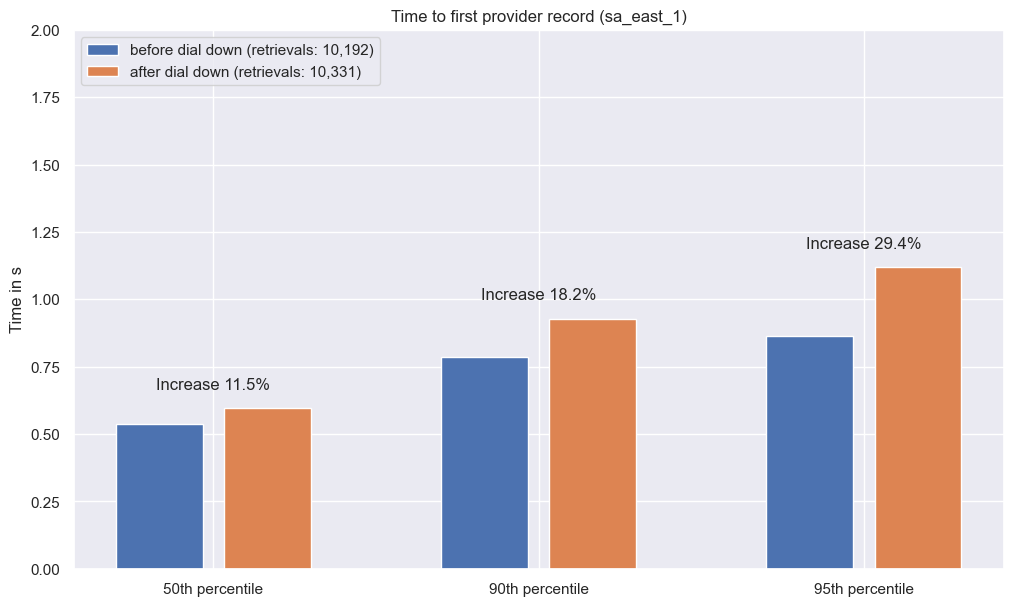

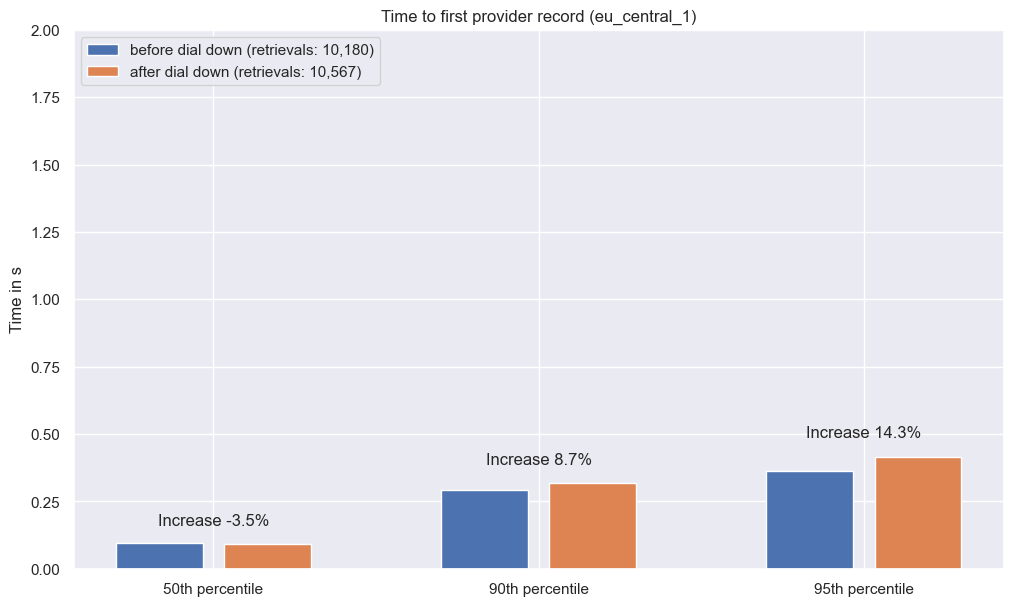

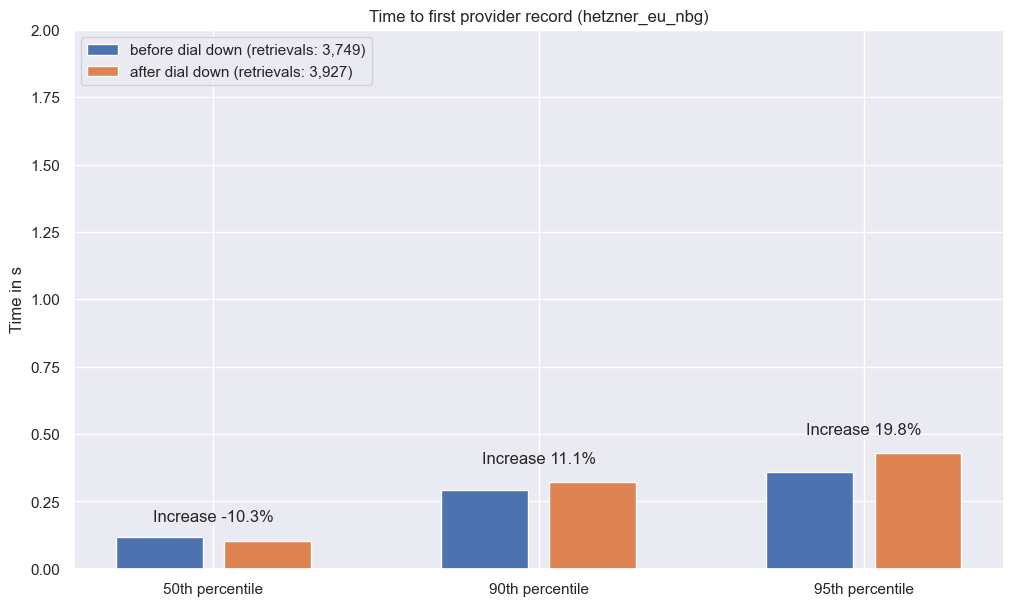

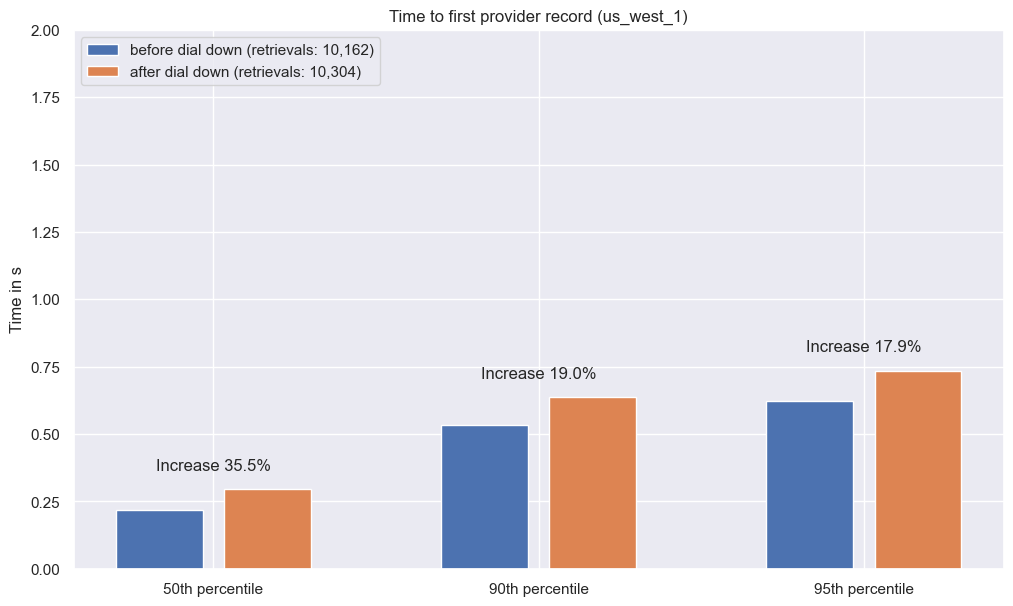

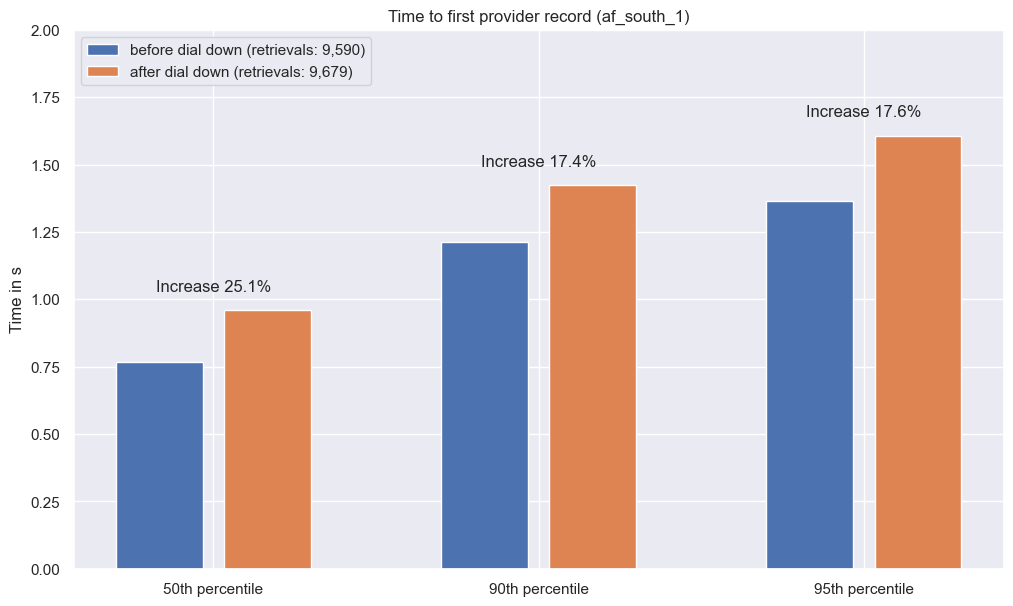

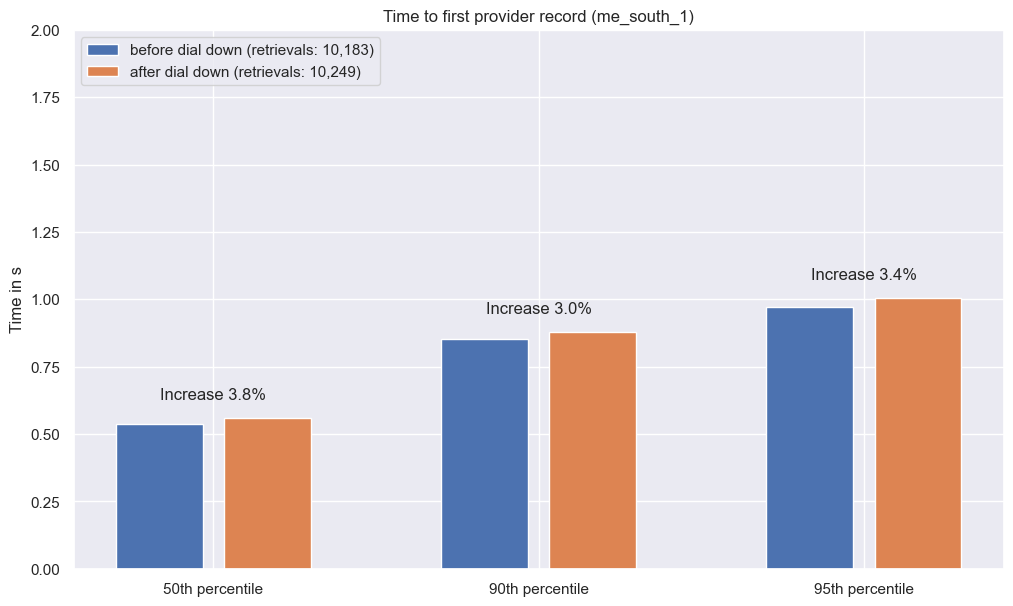

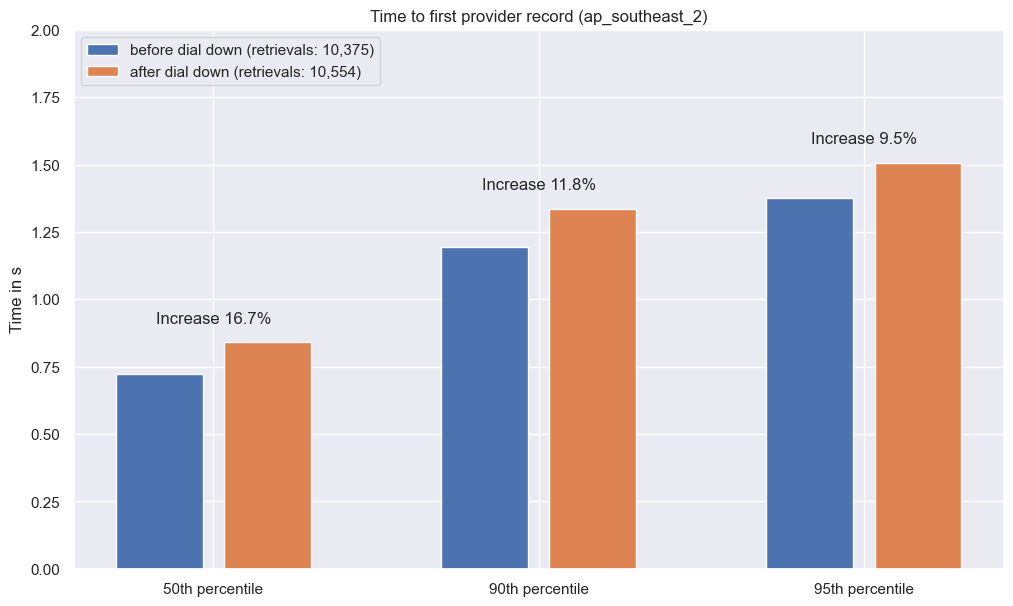

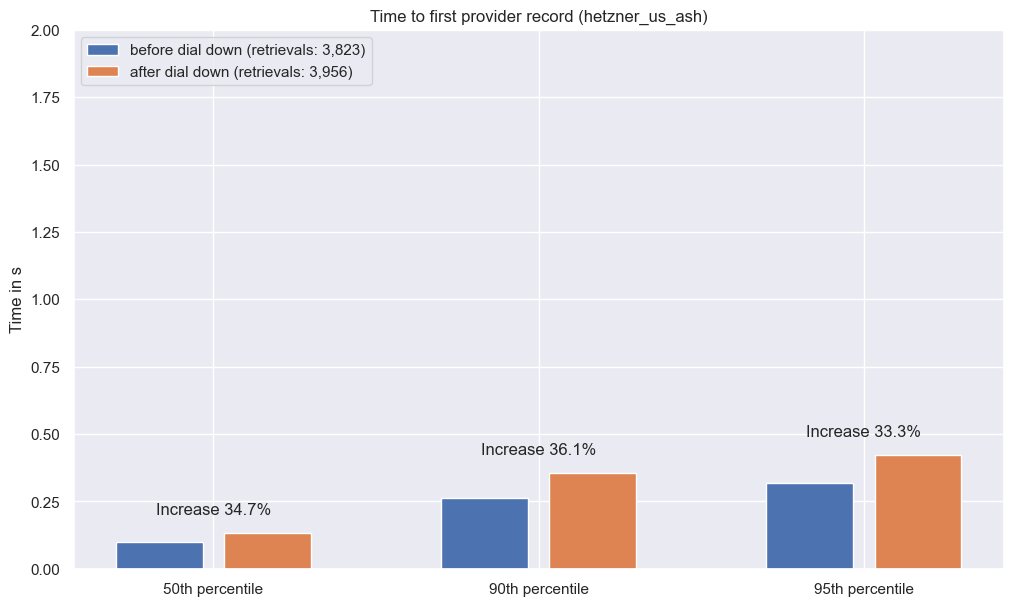

In [19]:

percentiles = [50, 90, 95]

for region in df_retrievals["region"].unique():
    fig, ax = plt.subplots(figsize=[12, 7])
    before_dial_down = df_retrievals[df_retrievals["with_hydras"] == True]
    before_dial_down = before_dial_down[before_dial_down["region"] == region]
    before_dial_down = before_dial_down[before_dial_down["started_at"] < "2022-12-01T17:30"]

    lats_before = []
    for j, percentile in enumerate(percentiles):
        lats_before += [np.percentile(before_dial_down["find_first_provider_duration"], percentile)]
    ax.bar([0, 3, 6], lats_before, label=f"before dial down (retrievals: {len(before_dial_down):,})")

    after_dial_down = df_retrievals[df_retrievals["with_hydras"] == True]
    after_dial_down = after_dial_down[after_dial_down["region"] == region]
    after_dial_down = after_dial_down[after_dial_down["started_at"] > "2022-12-01T17:30"]
    after_dial_down = after_dial_down[after_dial_down["started_at"] < "2022-12-07T09:00"]

    lats_after = []
    for j, percentile in enumerate(percentiles):
        lats_after += [np.percentile(after_dial_down["find_first_provider_duration"], percentile)]
    ax.bar([1, 4, 7], lats_after, label=f"after dial down (retrievals: {len(after_dial_down):,})")

    ax.text(0.5, np.max(lats_after[0]) + 0.07, f"Increase {100 * (lats_after[0] - lats_before[0]) / lats_before[0]:.1f}%",
            ha="center")
    ax.text(3.5, np.max(lats_after[1]) + 0.07, f"Increase {100 * (lats_after[1] - lats_before[1]) / lats_before[1]:.1f}%",
            ha="center")
    ax.text(6.5, np.max(lats_after[2]) + 0.07, f"Increase {100 * (lats_after[2] - lats_before[2]) / lats_before[2]:.1f}%",
            ha="center")

    ax.set_title(f"Time to first provider record ({region})")
    ax.set_xticks([0.5, 3.5, 6.5], list(map(lambda p: f"{p}th percentile", percentiles)))
    ax.set_ylabel("Time in s")
    ax.set_ylim(0, 2)
    ax.legend(loc="upper left")